# Data Assimilation using ESMDA in Reservoir Simulation

*Advanced Data Assimilation using Ensemble Smoother Multiple Data Assimilation (ESMDA) in Reservoir Simulation.*

This notebook demonstrates how to apply Ensemble Smoother Multiple Data Assimilation (ESMDA) in reservoir simulation. ESMDA is a data assimilation method that integrates observations and models to produce an improved estimate of the state of a system; in this case, a synthetic reservoir.

### Objectives

- Understand the ESMDA algorithm for data assimilation 
- Explore the effect of different ensemble sizes, perturbations, and number of assimilation steps
- Analyze the convergence and effectiveness of the ESMDA method in a synthetic reservoir model

### Prerequisites
- Knowledge of Python
- Familiarity with Data Assimilation Methods
- Understanding of Reservoir Simulation Models

## Understanding the reservoir simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import reservoir_simulator as rs

%load_ext autoreload
%autoreload 2   
%load_ext line_profiler
    
# Instantiate the random number generator
rng = np.random.default_rng()

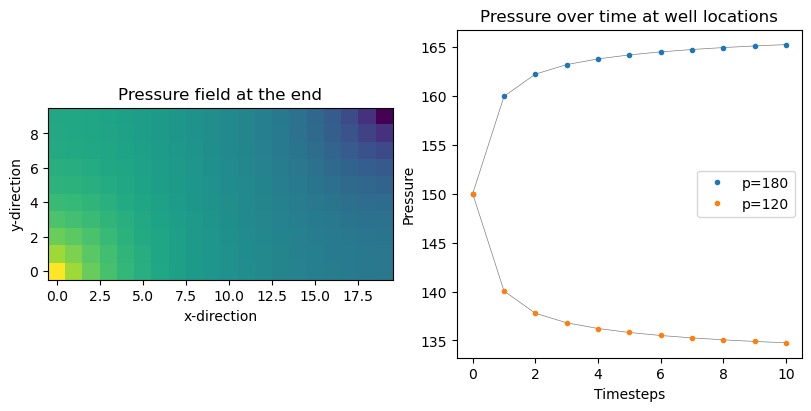

In [2]:
nx = 20 # 60
ny = 10 # 30
perm_field = np.ones((nx, ny)) * 100  # Replace with your actual perm field

#wells = np.array([[15, 10, 180], [55, 25, 120], [30, 7, 140]])
wells = None

Reservoir = rs.ReservoirSim(perm_field=perm_field, wells=wells)
pressure_history = Reservoir(dt=np.ones(10)*0.0001)

# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
ax1.set_title('Pressure field at the end')
ax1.imshow(pressure_history[-1, :, :].T, origin='lower', aspect='equal')
ax1.set_xlabel('x-direction')
ax1.set_ylabel('y-direction')
ax2.set_title('Pressure over time at well locations')
for w in Reservoir.wells:
    ax2.plot(pressure_history[:, w[0], w[1]], '.5', lw=0.5)
    ax2.plot(pressure_history[:, w[0], w[1]], '.', label=f"p={w[2]}")
ax2.legend()
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Pressure');

## Create permeability maps for for ESMDA

We will create a set of permeability maps that will serve as our initial guess (prior). These maps are generated using a Gaussian random field and are constrained by certain statistical properties.

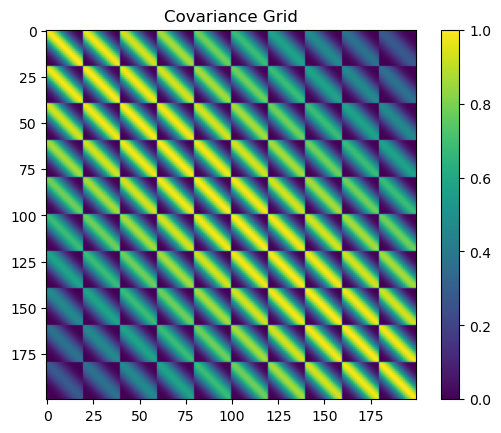

In [3]:
# Covariogram parameters 
length = (10, 10) 
theta = 45 * np.pi/180 # degrees to rad

# Generate the covariance matrix
cov = rs.build_perm_cov_matrix(nx, ny, length, theta)

fig, ax = plt.subplots()
ax.set_title('Covariance Grid')
im = ax.imshow(cov, aspect='equal')
fig.colorbar(im, ax=ax)

-----------

# Here; need to re-shape prior fields / perm fields; adjust plotting; fix lists

In [4]:
#%lprun -f rs.build_perm_cov_matrix rs.build_perm_cov_matrix(nx, ny, length, theta, sigma_pr2)

In [6]:
# Create 101 random permeability fields with mean 10 and std 1
Ne = 100
nc = nx*ny

# Generate the ensembles
mpr = np.full((nc,1),3.0)
lCholesky = np.linalg.cholesky(cov)
mList = []
for i in range(Ne+1): #+1 for the reference model
    z = np.random.normal(size=(nc,1))
    mList.append(mpr + lCholesky @ z)

#MGridPrior remove the first to be the reference model
#clip the mList to min = 0.5 and max = 5 (related to MGrid values)
bound_max= 5
bound_min= 0.5
mList = np.clip(mList, bound_min, bound_max)

mid_index = len(mList) // 2
# Set the middle element as the reference model
MReference = np.array(mList[mid_index])
# Slice the array to exclude the middle element
mList_without_middle = np.concatenate([mList[:mid_index], mList[mid_index+1:]])
# Use the remaining elements for MGridPrior
MGridPrior = np.transpose(np.array(mList_without_middle).reshape((Ne, nx, ny)))

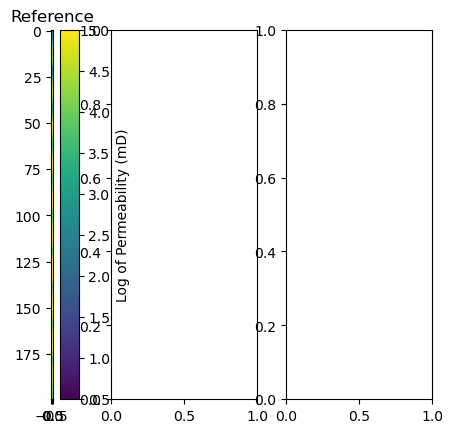

NameError: name 'plot_model_realization' is not defined

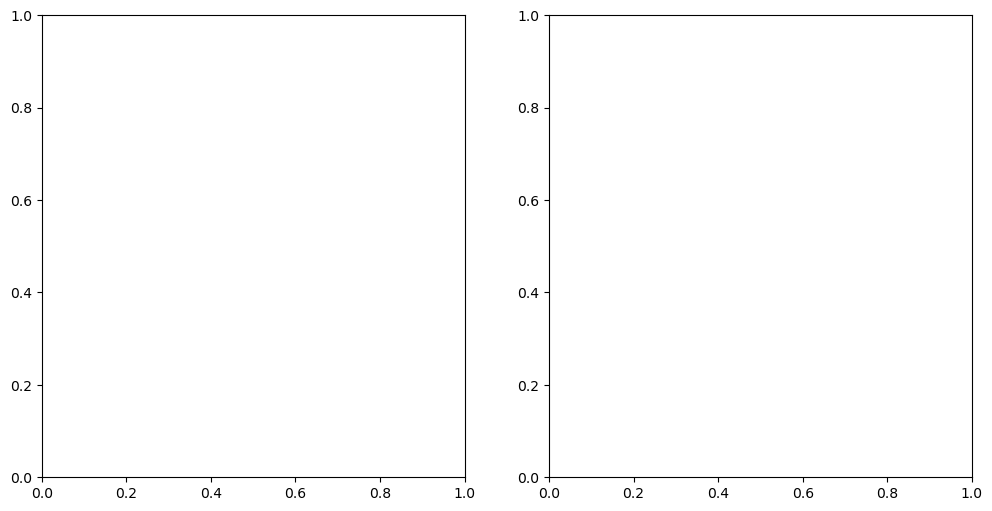

In [8]:
#plot the MReference
fig, axs = plt.subplots(1, 3)

axs[0].set_title('Reference')
im = axs[0].imshow(MReference, vmin=bound_min, vmax=bound_max)
fig.colorbar(im, ax=axs[0], label='Log of Permeability (mD)')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

# Create a figure and axis with a specific size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot your data (assuming PlotModelRealization is a custom function you have)
im = plot_model_realization(MGridPrior[:,0], 'Realization 0', ax[0], vmin=bound_min, vmax=bound_max)
plot_model_realization(MGridPrior[:,1], 'Realization 1', ax[1], vmin=bound_min, vmax=bound_max)
# Add colorbar
fig.colorbar(im, ax=ax, label='Log of Permeability (mD)')
# Add x and y labels
for axis in ax:
    axis.set_xlabel('X-axis')
    axis.set_ylabel('Y-axis')
    axis.set_xticks([])
    axis.set_yticks([])
# Show the plot
plt.show()

## Run the prior models and the reference case

In [25]:
#simulate all 101 fields
simulated_pressure_history = np.zeros((Ne, *pressure_history.shape))
for i, perm_field in enumerate(MGridPrior.T):
    reservoir = rs.ReservoirSim(perm_field=np.exp(perm_field), wells=wells)
    simulated_pressure_history[i, ...] = Reservoir(dt=np.ones(10)*0.0001)

simulated_pressure_history_prior = simulated_pressure_history
#getting only data we will use as observation
DPrior = simulated_pressure_history[:, :, 1, 1]

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
#simulate the reference field
reservoir = ReservoirSim(nx, ny, perm_field=np.exp(MReference))
pressure_history = reservoir.simulate()
reference_pressure_history = pressure_history.reshape((pressure_history.shape[0], nx,ny))


In [ ]:
#plot the monitored pressure at cell (1,1) for all 11 fields - consider the last simulation 101 as the reference case
for i in range(Ne):
    plt.plot(simulated_pressure_history[i,:,1,1], color='gray', alpha=0.5)
plt.plot(reference_pressure_history[:,1,1], label='reference case' , marker='o', linestyle='', color = 'red')


### Create the perturbed observations for ESMDA

We will create a set of perturbed observations that will serve as our observations for ESMDA. These observations are generated by adding a random noise to the reference case observations.

In [ ]:
#using the last model to create synthetic data
# Observations
dObs = reference_pressure_history[:,1,1].flatten()
Nd = len(dObs)
dstd = 2 * np.ones_like(dObs)
# Associated standard deviation: ones (for this scenario)
dstd = np.ones(dObs.size)*0.1
Ce = np.diag(dstd**2)


### ESMDA

Here we implement the ESMDA algorithm. This involves multiple assimilation steps, where we update our model parameters using observed data. The key components include:

Perturbing the observed data.

Calculating the Kalman gain.

Updating the model parameters.

Each assimilation step refines our model parameters, aiming to reduce the discrepancy between the model and the observed data.

In [ ]:
Na = 4 #number of assimilation steps
alphas = np.ones(Na)*Na
D=np.zeros((Nd,Ne))
MGrid=np.zeros((nc,Ne))

In [ ]:
l=0
D_iterations=[]
for alpha_idx, alpha in enumerate(alphas):
    print(f"\nAssimilation step {l}")  
    Dobs = np.transpose(dObs + alphas[0]*dstd*np.random.randn(Ne,Nd)) #perturb the observation for each ensemble member
    
    if l==0:   
        MGrid = MGridPrior
        D = DPrior 
        
    else:
        
        total_simulations = Ne
        
        simulated_pressure_history = np.zeros((Ne, pressure_history.shape[0], nx, ny))
        for i, perm_field in enumerate(MGrid.T):
            reservoir = ReservoirSim(nx, ny, perm_field=np.exp(perm_field))
            pressure_history = reservoir.simulate()
            simulated_pressure_history[i,...] = pressure_history.reshape((pressure_history.shape[0], nx,ny))
        #getting only data we will use as observation
        D = simulated_pressure_history[:,:,1,1]   
        

    D_iterations.append(D)

            
   
    deltaM = np.transpose(MGrid.T-MGrid.mean(axis=1)) #mean of the ensemble parameters
    deltaD = D.T-D.mean(axis=1) #mean of the ensemble data
    K = (deltaM@deltaD.T)@np.linalg.inv((deltaD@deltaD.T + alphas[0]*(Ne-1)*Ce)) #Kalman gain
    Mnew = MGrid + K@(Dobs-D.T) #update the ensemble parameters
    MGrid= np.clip(Mnew, bound_min, bound_max) #clip the ensemble parameters to min = 0.5 and max = 5 (related to MGrid values)  
       
    
    
    l += 1
MGridPost = MGrid


### Posterior Analysis
After running ESMDA, it's crucial to analyze the posterior ensemble of models. Here, we visualize the first three realizations from both the prior and posterior ensembles to see how the models have been updated.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].imshow(MGridPrior.mean(axis=1).reshape(nx,ny), label = 'Prior Mean')
ax[0].set_title('Prior Mean')
ax[1].imshow(MGridPost.mean(axis=1).reshape(nx,ny), label= 'Post Mean')
ax[1].set_title('Post Mean')
plt.show()

In [ ]:
#Run the posterior
simulated_pressure_history = np.zeros((Ne, pressure_history.shape[0], nx, ny))
for i, perm_field in enumerate(MGridPost.T):
    reservoir = ReservoirSim(nx, ny, perm_field=np.exp(perm_field))
    pressure_history = reservoir.simulate()
    simulated_pressure_history[i,...] = pressure_history.reshape((pressure_history.shape[0], nx,ny))
DPost = simulated_pressure_history[:,:,1,1]

Observing the monitored pressure at cell (1,1) for all realizations and the reference case, we can see that the ensemble of models after the assimilation steps (in blue) is closer to the reference case (in red) than the prior ensemble (in gray). This indicates that the ESMDA method is effectively updating the models to better represent the observed data.

In [ ]:
#plot the monitored pressure at cell (1,1) for all 11 fields - consider the last simulation 101 as the reference case
noisy_obs = dObs + np.random.normal(0, dstd , size=len(dObs))

for i in range(Ne):
    plt.plot(DPrior[i,:], color='gray', alpha=0.5)
    plt.plot(DPost[i,:], color='blue', alpha=0.5)
plt.plot(noisy_obs, label='reference case' , marker='o', linestyle='', color = 'red')